In [1]:
import logging
import sys
import time
import boto3
from botocore.exceptions import ClientError

logger = logging.getLogger(__name__)
sqs = boto3.resource('sqs', 'us-west-2')

## Stream component composition example
In this example we illustrate using funcX to create disgtributed component that can process streams of input messages.  Each component waits for messages on an input queue, processes the messages and passes the results to another component or saves the result to an on-line storage component.   

Each component instance consists of an input queue and one or more instances of a funcx invocation associated with a supplied funcx endpoint.   In order to guarentee termination we require that each funcx invocation be limited to a maximum number of messages processed.   We must also require that the input queues have a timeout if no input is seen withing a prescribed amount of time.   So if the max number of invocations is max_num and the input queue timeout is 5 seconds, then the function will terminate within max_num*5 seconds.   We also program the function to have an early exit condition so that they will return if the message "Stop" is recieved.   

In this example we will use AWS Simple Queue Service for the queues (because they have the require timeout-on-empty-queue property).  We have two components:

1. A Front-end component that recieves messages and processes them in FIFO order.  If the message is "forward" it passes the message to a Back-end component.   Otherwise if the message is not "Stop", it processes message and stores the result in a table.  The table we use is in Azure Storage Service becuase it is cheap and reliable.  

2. The Back-end component consists of one or more instances of a backend processor functions which pull messages from the input queue for that component.   We can control throughput of the back-end component by increasing or decreasing the numbere of functions servicing the queue.   When the back-end processing functions complete and execution they store the result in the queue.


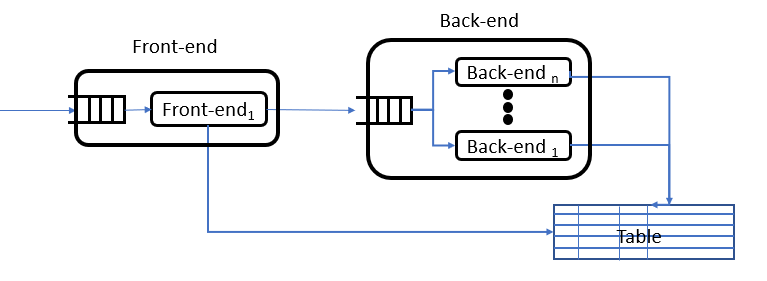

## AWS Simple Queue Service Management Function

We copy several SQS helper functions taken from the SQS tutorial samples.  We are creating FIFO queues without content-based deduplication.   

In [2]:
def create_queue(name, attributes=None):
    """
    Creates an Amazon SQS queue.

    Usage is shown in usage_demo at the end of this module.

    :param name: The name of the queue. This is part of the URL assigned to the queue.
    :param attributes: The attributes of the queue, such as maximum message size or
                       whether it's a FIFO queue.
    :return: A Queue object that contains metadata about the queue and that can be used
             to perform queue operations like sending and receiving messages.
    """
    if not attributes:
        attributes = {'FifoQueue':'true', 'ContentBasedDeduplication':'false'}

    try:
        queue = sqs.create_queue(
            QueueName=name,
            Attributes=attributes
        )
        logger.info("Created queue '%s' with URL=%s", name, queue.url)
    except ClientError as error:
        logger.exception("Couldn't create queue named '%s'.", name)
        raise error
    else:
        return queue


In [3]:
def get_queue(name):
    """
    Gets an SQS queue by name.

    Usage is shown in usage_demo at the end of this module.

    :param name: The name that was used to create the queue.
    :return: A Queue object.
    """
    try:
        queue = sqs.get_queue_by_name(QueueName=name)
        logger.info("Got queue '%s' with URL=%s", name, queue.url)
    except ClientError as error:
        logger.exception("Couldn't get queue named %s.", name)
        raise error
    else:
        return queue

In [4]:
def remove_queue(queue):
    """
    Removes an SQS queue. When run against an AWS account, it can take up to
    60 seconds before the queue is actually deleted.

    Usage is shown in usage_demo at the end of this module.

    :param queue: The queue to delete.
    :return: None
    """
    try:
        queue.delete()
        logger.info("Deleted queue with URL=%s.", queue.url)
    except ClientError as error:
        logger.exception("Couldn't delete queue with URL=%s!", queue.url)
        raise error


In [5]:
def send_message(queue, message_body, message_attributes=None):
    """
    Send a message to an Amazon SQS queue.

    Usage is shown in usage_demo at the end of this module.

    :param queue: The queue that receives the message.
    :param message_body: The body text of the message.
    :param message_attributes: Custom attributes of the message. These are key-value
                               pairs that can be whatever you want.
    :return: The response from SQS that contains the assigned message ID.
    """
    if not message_attributes:
        message_attributes = {}

    try:
        response = queue.send_message(
            MessageBody=message_body,
            MessageAttributes=message_attributes,
            MessageGroupId='funcx',
            MessageDeduplicationId=str(time.time())
            
        )
    except ClientError as error:
        logger.exception("Send message failed: %s", message_body)
        raise error
    else:
        return response

## The FuncX part of the experiment starts here.

In [6]:
from funcx.sdk.client import FuncXClient
import time
fxc = FuncXClient()

We will use two remote resources.  One is the small jetbot and the other is a kubernetes cluster.  these have been changed to proctect these resources

In [7]:
epjb = 'a7c14a88-xxxx-41ae-963f-7b419e29e6dd' #jetbot
ep = '6cd44687-762b-xxxx-ac07-1918a3cddecd' #k8s pc

To run this you will need a azure storage acount.  don't worry.  you can get a free account.  you will also need an aws account.  these are both very low cost services.

In [8]:
accnts = {"az_name":"parslstorage",
          "az_key":"your-azure-storage-key-here",
          'aw_id':"your-aws-id",
          'aw_sec_key':"your-aws-secret-key"}

### The back-end functions
The back-end will listen for data on an input queue, then do  some work and then publish the result in a table in the cloud.  We use Azure storage table for that.  

Back-end takes the name of the input queue,  the maximum nuber of messages it should consume.  Recall that if it does not see anything in the queue for five seconds the receive_messsage queue call will time out.  So the longest this function will run is max_msgs\*5 seconds.  If the function gets a "Stop" action signal it returns.  Otherwises it does the work and pushes the result to the queue. 

The listernID parameter is a string to identify this listener.  Becuase the function executes remotely we need to pass along some account permisions for the table and the queue service.  

#### the message format
all the messages are simple python dictionaries with one required key "action".  the messages are passed as string and we just JSON to decode them.  The function decode_msg(m) decodes and deletes the mssage from the queue.  

In [9]:
def back_end(queue_in, table_name, num_msgs, listenerID, accnts):
    import boto3
    from botocore.exceptions import ClientError
    import time 
    from azure.data.tables import TableClient
    from random import random
    import json
    
    #first set up azure table to record results
    constr = "DefaultEndpointsProtocol=https;AccountName=%s;AccountKey=%s"%(accnts['az_name'],accnts['az_key'])
    table = TableClient.from_connection_string(conn_str=constr, table_name=table_name) #"funcxtable")
    #next get the fifo queue from AWS based on the name of the queue
    
    sqs = boto3.resource('sqs', 'us-west-2',    
        aws_access_key_id=accnts['aw_id'],
        aws_secret_access_key=accnts['aw_sec_key'])
    q_in = sqs.get_queue_by_name(QueueName=queue_in)
    
    def receive_message(queue, max_number, wait_time):
        try:
            messages = queue.receive_messages(
                MessageAttributeNames=['All'],
                MaxNumberOfMessages=max_number,
                WaitTimeSeconds=wait_time
            )
        except ClientError as error:
            raise error
        else:
            return messages
    
    def send_message(queue, message_body):
        try:
            response = queue.send_message(
                MessageBody=message_body,
                MessageAttributes={},
                MessageGroupId='funcx',
                MessageDeduplicationId=str(time.time())

            )
        except ClientError as error:
            logger.exception("Send message failed: %s", message_body)
            raise error
        else:
            return response
        
    def save_data_in_table(listenerID, key, t, record):
        my_entity = {'PartitionKey':listenerID,'RowKey':str(key), 'time':str(t), 'text':record}
        #print(my_entity)
        entity = table.create_entity(entity=my_entity)
        #print(entity)
    
    def decode_msg(m):
        bod = m[0].body
        m[0].delete()
        action = ''
        try:
            action = json.loads(bod)['action']
        except:
            action = 'bad msg'
        return action

    def compute_pi(numpoints):
        inside = 0
        for j in range(numpoints):
            x, y = random(), random()  # Drop a random point in the box.
            if x**2 + y**2 < 1:        # Count points within the circle.
                inside += 1
        pi = inside*4 / numpoints
        return pi

    # the following look will pull at most num_msgs from the queue
    #if the queue is empty it will wait 5 seconds and time out
    #try again.
    msgs = []
    msgkey = 1
    action = ''
    for i in range(num_msgs):
        t0 = time.time()
        m = receive_message(q_in, 1, 5)
        # m should be a list of length 1 unless the queue is 
        # empty and it times out after 5
        if m != []:
            action = decode_msg(m)
            if action == 'Stop':
                return msgs
            else:
                # now worthless computaiton
                pi = compute_pi(10**7)
             
                #now save in table for later analysis
                save_data_in_table(listenerID, msgkey, t0, action+' '+str(pi))
                msgkey += 1
            msgs.append((action, t0))
    return msgs

### The Front-end function
The front-end takes input messages from queue_in.  Then if the action in the mssage is not "Stop" it either does a local computation and places it in the table or, if it sees the action "forward" it sends the message to queue_out for further processing.   num_msges, ListenerID and accnts are as above.

In [10]:
def front_end( queue_in, queue_out, num_msgs, listenerID, accnts):
    import boto3
    from botocore.exceptions import ClientError
    import time 
    from azure.data.tables import TableClient
    from random import random
    import json
    
    #first set up azure table to record results
    constr = "DefaultEndpointsProtocol=https;AccountName=%s;AccountKey=%s"%(accnts['az_name'],accnts['az_key'])
    table = TableClient.from_connection_string(conn_str=constr, table_name="funcxtable")
    #next get the fifo queue from AWS based on the name of the queue
    
    #We also need helper functions for taking messages out of the queues, putting them in the queues, 
    #putting data in the table and decoding the messages
    sqs = boto3.resource('sqs', 'us-west-2',    
        aws_access_key_id=accnts['aw_id'],
        aws_secret_access_key=accnts['aw_sec_key'])
    q_in = sqs.get_queue_by_name(QueueName=queue_in)
    q_out= sqs.get_queue_by_name(QueueName=queue_out)
    
    def receive_message(queue, max_number, wait_time):
        try:
            messages = queue.receive_messages(
                MessageAttributeNames=['All'],
                MaxNumberOfMessages=max_number,
                WaitTimeSeconds=wait_time
            )
        except ClientError as error:
            raise error
        else:
            return messages
    
    def send_message(queue, message_body):
        try:
            response = queue.send_message(
                MessageBody=message_body,
                MessageAttributes={},
                MessageGroupId='funcx',
                MessageDeduplicationId=str(time.time())

            )
        except ClientError as error:
            logger.exception("Send message failed: %s", message_body)
            raise error
        else:
            return response
        
    def save_data_in_table(listenerID, key, t, record):
        my_entity = {'PartitionKey':listenerID,'RowKey':str(key), 'time':str(t), 'text':record}
        #print(my_entity)
        entity = table.create_entity(entity=my_entity)
        #print(entity)
    
    def decode_msg(m):
        bod = m[0].body
        m[0].delete()
        action = ''
        try:
            action = json.loads(bod)['action']
        except:
            action = 'bad msg'
        return action, bod

    def compute_pi(numpoints):
        inside = 0
        for j in range(numpoints):
            x, y = random(), random()  # Drop a random point in the box.
            if x**2 + y**2 < 1:        # Count points within the circle.
                inside += 1
        pi = inside*4 / numpoints
        return pi

    # the following look will pull at most num_msgs from the queue
    #if the queue is empty it will wait 5 seconds and time out
    #try again for a total of num_msgs attempts.
    msgs = []
    msgkey = 1
    action = ''
    for i in range(num_msgs):
        t0 = time.time()
        m = receive_message(q_in, 1, 5)
        # m should be a list of length 1 unless the queue is 
        # empty and it times out after 5 sec
        if m != []:
            action, body = decode_msg(m)
            if action == 'Stop':
                break
            elif action == 'forward':
                send_message(q_out, '{"action":"dopi", "key":%s}'%str(msgkey))
            else:
                # now worthless computaiton
                pi = compute_pi(10**7)
             
                #now save in table for later analysis
                save_data_in_table(listenerID, msgkey, t0, action+'  '+str(pi))
                msgkey += 1
            msgs.append((action, t0))
    #the following will stop up to 2 back-end functions.  not very elegant.
    send_message(q_out, '{"action":"Stop"}')
    send_message(q_out, '{"action":"Stop"}')

    return msgs

In [11]:
## we previously invoked create queue so we don't need to do it again.
#create_queue('funcx-queue2.fifo')
#create_queue('funcx-queue1.fifo')

q1 = get_queue('funcx-queue1.fifo')
q2 = get_queue('funcx-queue2.fifo')

The following look prepositions 20 messages in the input queue for the front end.  it also adds a stop signal at the end. 

In [29]:
for i in range(10):
    send_message(q1, '{"action":"dopi%s"}'%str(i+13))
    time.sleep(0.2)
    send_message(q1, '{"action":"forward", "index":%s}'%str(i+13))
    time.sleep(0.2)
send_message(q1, '{"action":"Stop"}')


{'MD5OfMessageBody': '09536f92f0e07252f5018a048be75129',
 'MessageId': '50f0649a-4acb-4662-ba57-c444d95b2d9f',
 'SequenceNumber': '18858584763188976128',
 'ResponseMetadata': {'RequestId': '2005c431-c165-5682-9eff-9c6c6110dff8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2005c431-c165-5682-9eff-9c6c6110dff8',
   'date': 'Wed, 23 Dec 2020 19:44:53 GMT',
   'content-type': 'text/xml',
   'content-length': '431'},
  'RetryAttempts': 0}}

In [13]:
func_front = fxc.register_function(front_end)
func_back = fxc.register_function(back_end)

### Creating the component instances
The following simple wrapper creates an instance of the components.   it is rather simple minded.  parameters are:

1. the base name  of the component (like "Front" or "Back")
2. the name of the input queue for this component.
3. the output name which could be another queue name or the table name.
4. repl_factor: the number of function instances of the type of func_id to create
5. the end_point that will be the host service for the function instances
6. func_id the uuid of the function resulting from funcx registration as above

In [30]:
def launch_component(component_name, input_name, output_name, repl_factor, end_point, func_id):
    result_list = []
    for i in range(repl_factor):
        #                queue_in, table_name, num_msgs, listenerID, accnts)
        res = fxc.run(input_name, output_name, 50, component_name+'_'+str(i), accnts, endpoint_id=end_point, function_id=func_id )
        result_list.append(res)
    return input_name, result_list

In [31]:
front_res = launch_component('Front', 'funcx-queue1.fifo','funcx-queue2.fifo', 1, epjb, func_front)

In [32]:
front_res

('funcx-queue1.fifo', ['2b24b6ef-8a6a-4e2c-9cd7-752173abd568'])

In [34]:
back_res = launch_component('Back_', 'funcx-queue2.fifo', "funcxtable", 2, ep, func_back)

The following is the output at the the execution 

In [38]:
fxc.get_task(front_res[1][0])

{'pending': False,
 'status': 'success',
 'result': [('dopi13', 1608752704.406051),
  ('forward', 1608752722.0790133),
  ('dopi14', 1608752722.2293665),
  ('forward', 1608752739.3932536),
  ('dopi15', 1608752739.5322533),
  ('forward', 1608752755.804505),
  ('dopi16', 1608752755.954178),
  ('forward', 1608752772.5702667),
  ('dopi17', 1608752772.7165003),
  ('forward', 1608752788.8295236),
  ('dopi18', 1608752788.9781418),
  ('forward', 1608752805.7692058),
  ('dopi19', 1608752805.9294229),
  ('forward', 1608752822.7602978),
  ('dopi20', 1608752822.8924305),
  ('forward', 1608752840.1775823),
  ('dopi21', 1608752840.4072325),
  ('forward', 1608752857.2812035),
  ('dopi22', 1608752857.4195151),
  ('forward', 1608752872.9318535)],
 'completion_t': '1608752873.5044572'}

In [39]:
back_res

('funcx-queue2.fifo',
 ['c81377f9-45ea-478f-bc36-8cdccd621d5c',
  '8fbb8b56-fc64-4319-8895-33ff14e5d679'])

In [41]:
fxc.get_task(back_res[1][0])

{'pending': False,
 'status': 'success',
 'result': [('dopi', 1608752719.0520577),
  ('dopi', 1608752735.008718),
  ('dopi', 1608752751.9321816),
  ('dopi', 1608752768.4061282)],
 'completion_t': '1608752873.4812376'}

In [50]:
fxc.get_task(back_res[1][1])

{'pending': False,
 'status': 'success',
 'result': [('dopi', 1608752785.0623498),
  ('dopi', 1608752801.7677984),
  ('dopi', 1608752818.4912758),
  ('dopi', 1608752840.4845934),
  ('dopi', 1608752853.0572288),
  ('dopi', 1608752869.953129)],
 'completion_t': '1608752875.1620994'}

In [37]:
#send a final stop message to q2.  

The following image shows the table content in the azure storage explorer at the end of the execution.  We show below how to pull this table into the notebook and render it as a pandas dataframe.

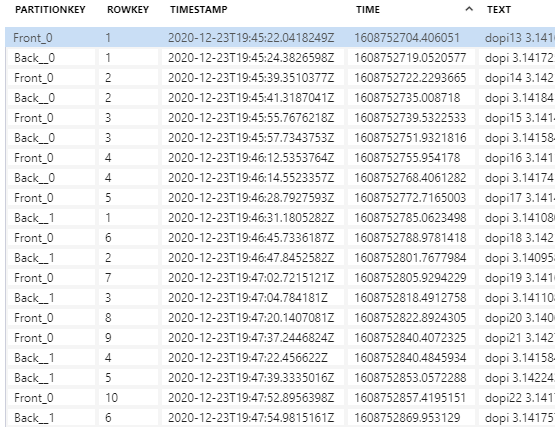

##### An easy way to clear any leftover items in the queues

In [27]:
def pull_item_from_queue(queue, max_number, wait_time):
    try:
        messages = queue.receive_messages(
            MessageAttributeNames=['All'],
            MaxNumberOfMessages=max_number,
            WaitTimeSeconds=wait_time
        )
    except ClientError as error:
        raise error
    else:
        return messages
    return messages
   
for i in range(2):
    m =pull_item_from_queue(q2, 1, 2)
    if m != []:
        print( m[0].body)
        m[0].delete()
        

{"action":"Stop"}


##### Pull data from the table
this pull the data from the table, delete the data in the table and then generates a pandas data frame and saves the data to a file.

In [42]:
from azure.data.tables import TableClient
constr = "DefaultEndpointsProtocol=https;AccountName=%s;AccountKey=%s"%(accnts['az_name'],accnts['az_key'])
table = TableClient.from_connection_string(conn_str=constr, table_name="funcxtable")


In [43]:
times = []
for x in table.list_entities():
    times.append(x)
    #print(x)
    table.delete_entity(x['PartitionKey'],x['RowKey'])

In [44]:
import pandas as pd

In [45]:
timesfor1 = pd.DataFrame(times)

In [46]:
gfg_csv_data = timesfor1.to_csv('timefor1.csv', index = True)

In [49]:
sorted_by_time = timesfor1.sort_values(by=['time'])
sorted_by_time

,PartitionKey,RowKey,time,text,_metadata
10,Front_0,1,1608752704.406051,dopi13 3.1416344,"{'etag': 'W/""datetime'2020-12-23T19%3A45%3A22...."
0,Back__0,1,1608752719.0520577,dopi 3.1417256,"{'etag': 'W/""datetime'2020-12-23T19%3A45%3A24...."
12,Front_0,2,1608752722.2293665,dopi14 3.1421384,"{'etag': 'W/""datetime'2020-12-23T19%3A45%3A39...."
1,Back__0,2,1608752735.008718,dopi 3.1418416,"{'etag': 'W/""datetime'2020-12-23T19%3A45%3A41...."
13,Front_0,3,1608752739.5322533,dopi15 3.141416,"{'etag': 'W/""datetime'2020-12-23T19%3A45%3A55...."
2,Back__0,3,1608752751.9321816,dopi 3.1415844,"{'etag': 'W/""datetime'2020-12-23T19%3A45%3A57...."
14,Front_0,4,1608752755.954178,dopi16 3.1411736,"{'etag': 'W/""datetime'2020-12-23T19%3A46%3A12...."
3,Back__0,4,1608752768.4061282,dopi 3.1417416,"{'etag': 'W/""datetime'2020-12-23T19%3A46%3A14...."
15,Front_0,5,1608752772.7165003,dopi17 3.14148,"{'etag': 'W/""datetime'2020-12-23T19%3A46%3A28...."
4,Back__1,1,1608752785.0623498,dopi 3.1410804,"{'etag': 'W/""datetime'2020-12-23T19%3A46%3A31...."


In [56]:
pivals = []
for x in sorted_by_time['text']:
    b = x.find(' ')
    pivals.append(float(x[b+1:]))

In [59]:
import numpy as np

In [60]:
np.mean(pivals)

3.14161792

In [61]:
# obviously not a very good way to compute pi